# Laboratorio 3: SHAP MedMNIST

## ========= 1) Setup =========

In [1]:
# Install required libraries if needed
# !pip install medmnist torch torchvision shap matplotlib

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import shap
import numpy as np
import random
import os

import medmnist
from medmnist import INFO


import torch.nn as nn
import torch.nn.functional as F

## ========= 2) Dataset Info =========

In [2]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
id2label = {int(k): v for k, v in info['label'].items()}

print(f"Dataset: {info['description']}")
print(f"Task: {info['task']}, Classes: {n_classes}")
print("Classes:", id2label)

Dataset: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Task: multi-class, Classes: 9
Classes: {0: 'adipose', 1: 'background', 2: 'debris', 3: 'lymphocytes', 4: 'mucus', 5: 'smooth muscle', 6: 'normal colon mucosa', 7: 'cancer-associated stroma', 8: 'colorectal adenocarcinoma epithelium'}


## ========= 3) Load dataset =========

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32549018..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.90588236].


Train size: 89996  Test size: 7180


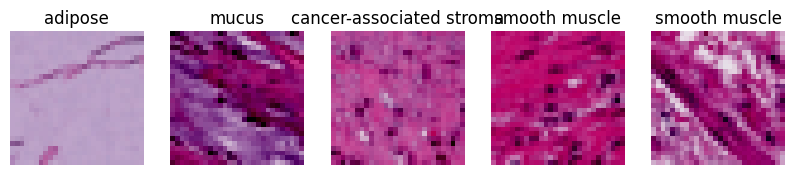

In [3]:
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset  = DataClass(split='test', transform=transform, download=download)

print("Train size:", len(train_dataset), " Test size:", len(test_dataset))

# Show 5 sample images
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_dataset[i]

    # Ensure img is a numpy array
    if isinstance(label, torch.Tensor):
        lbl = label.item()
    elif isinstance(label, np.ndarray):
        lbl = label.item()
    else:
        lbl = label

    img = img.numpy().transpose(1, 2, 0).squeeze()
    axs[i].imshow(img, cmap="gray")
    axs[i].set_title(f"{id2label[int(lbl)]}")  # ✅ cast label to int
    axs[i].axis("off")
plt.show()

## ========= 4) Define Simple CNN Model (already provided) =========

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*14*14, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

model = SimpleCNN(info['n_channels'], n_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model class defined and ready.")

Model class defined and ready.


## ========= 5) Load Pretrained Model =========

In [5]:
MODEL_PATH = "pathmnist_simplecnn.pth"

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("Pretrained model loaded successfully!")

Pretrained model loaded successfully!


## ========= 6) Predictions + SHAP Explanations =========

**In this cell, you will:**
1. Write a helper function so SHAP can call the model
2. Pick one test image and predict its class
3. Compare prediction vs. true label
4. Use SHAP to explain WHY the model made that prediction
5. Visualize the results

## ========= 6) Predictions + SHAP Explanations =========

In [6]:
# In this cell, you will:
#   1. Write a helper function so SHAP can call the model
#   2. Pick one test image and predict its class
#   3. Compare prediction vs. true label
#   4. Use SHAP to explain WHY the model made that prediction
#   5. Visualize the results

### --- Step 1: Helper function for SHAP ---

In [7]:
def model_forward(x):
    if isinstance(x, list):
        x = np.stack(x, axis=0)
    x = x.astype(np.float32)

    # Case 1: [0, 255] -> [0,1] Normalization
    if x.max() > 1.0:
        x = x / 255.0

    # Case 2: if it's already roughly [-1,1], skip; if [0,1], normalize to [-1,1]
    # (tolerant thresholds to avoid floating noise)
    xmin, xmax = x.min(), x.max()
    if xmin >= -1.5 and xmax <= 1.5:
        # assume already normalized by dataset; do nothing
        x = x
    else:
        # assume [0,1]; normalize like the dataset did
        x = (x - 0.5) / 0.5

    # NHWC -> NCHW and to device
    xt = torch.from_numpy(x).permute(0, 3, 1, 2).to(device)
    # Inference
    with torch.no_grad():
        logits = model(xt) # (N, n_classes) logits
        probs = torch.softmax(logits, dim=1).cpu().numpy() # (N, n_classes) probs
        
    return probs

### --- Step 2: Pick one test image ---

In [8]:
# Pick a sample (you can change the index for variety)
idx = 0
sample_img, sample_label = test_dataset[idx]

# Convert tensor to numpy with shape (1, H, W, C)
np_img = sample_img.permute(1, 2, 0).numpy()[None, ...]

# Predict
probs = model_forward(np_img)[0]  # shape (n_classes,)
pred_idx = np.argmax(probs)
pred_prob = probs[pred_idx]
true_idx = sample_label.item() if hasattr(sample_label, "item") else int(sample_label)

# Show results
print(f"Predicted: {id2label[pred_idx]} ({pred_prob:.2f})")
print(f"True label: {id2label[int(true_idx)]}")

Predicted: normal colon mucosa (0.71)
True label: colorectal adenocarcinoma epithelium


### --- Step 3: Prepare image for SHAP ---

In [9]:
# Convert sample image (C, H, W) -> (H, W, C)
shap_img = sample_img.permute(1, 2, 0).numpy()

print("SHAP image shape:", shap_img.shape)  # (H, W, C)

SHAP image shape: (28, 28, 3)


### --- Step 4: Create SHAP explainer ---

In [10]:
# Ensure we have the image in (H, W, C) and a batch
x_batch = shap_img[None, ...].astype(np.float32)  # (1, H, W, C)

# 1) Create an image masker (blur-based)
masker = shap.maskers.Image("blur(28,28)", x_batch[0].shape)

# 2) Create the explainer with your forward function
explainer = shap.Explainer(
    model_forward,
    masker,
    output_names=[id2label[i] for i in range(n_classes)]
)

# 3) Run the explainer on the chosen image
shap_values = explainer(x_batch, max_evals=500)

### --- Step 5: Visualize ---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..0.9137255].


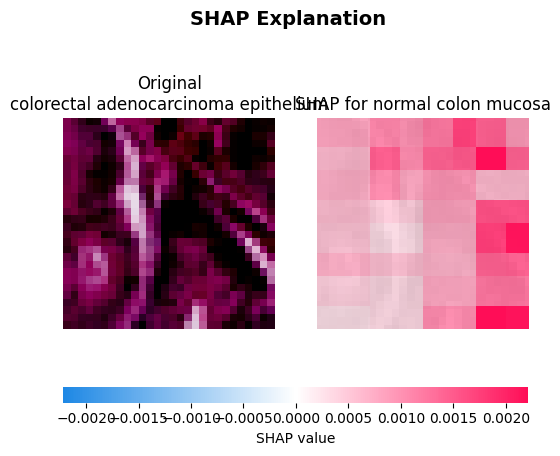

In [11]:
# Make sure we have the image as a batch
x_batch = shap_img[None, ...].astype(np.float32)

# Get integer true label for printing
true_idx = sample_label.item() if hasattr(sample_label, "item") else int(sample_label)

# Slice to get just the predicted class → (N, H, W, C)
shap.image_plot(shap_values.values[..., pred_idx], x_batch, show=False)

fig = plt.gcf()            # get current figure
axs = fig.axes             # shap.image_plot creates subplots internally

# Add subtitles
axs[0].set_title(f"Original\n{id2label[true_idx]}")
axs[1].set_title(f"SHAP for {id2label[pred_idx]}")

# Add main title
fig.suptitle("SHAP Explanation", fontsize=14, weight="bold")

plt.show()

## ========= 7) Extension: Multiple Images =========

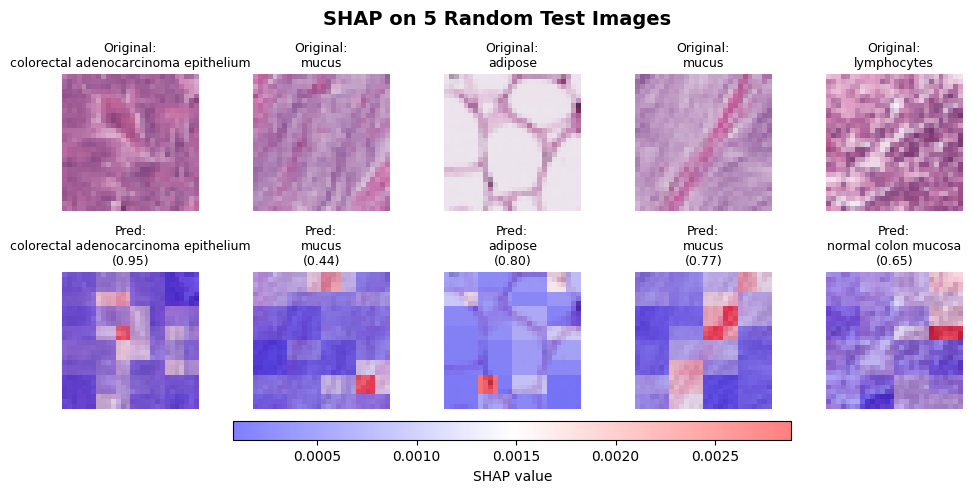

In [12]:
# Pick 5 random indices
k = 5
idxs = random.sample(range(len(test_dataset)), k)

# Build a batch (N, H, W, C) and store true labels
imgs_np = []
true_idxs = []
for i in idxs:
    img_t, lbl = test_dataset[i]                 # img_t: (C,H,W), lbl: tensor/np/int
    imgs_np.append(img_t.permute(1, 2, 0).numpy())  # -> (H,W,C)
    true_idxs.append(int(lbl.item() if hasattr(lbl, "item") else lbl))

x_batch = np.stack(imgs_np, axis=0).astype(np.float32)  # (N,H,W,C)

# Predict (probs + predicted class)
probs_batch = model_forward(x_batch)                    # (N, n_classes)
pred_idxs = probs_batch.argmax(axis=1)
pred_probs = probs_batch[np.arange(k), pred_idxs]

# Explain with SHAP (single batch call)
shap_values_batch = explainer(x_batch, max_evals=500)   # values: (N,H,W,C,n_outputs)

# De-normalize for DISPLAY only (avoid clipping warnings)
disp_batch = np.clip(x_batch * 0.5 + 0.5, 0, 1)  # (N,H,W,C) in [0,1]

# 2 rows × k cols: top originals, bottom SHAP overlays
fig, axes = plt.subplots(2, k, figsize=(2.4*k, 5))

im_last = None # Keep track of the last image for colorbar

for j in range(k):
    # Top: original + true label
    axes[0, j].imshow(disp_batch[j])
    axes[0, j].set_title(f"Original:\n{id2label[true_idxs[j]]}", fontsize=9)
    axes[0, j].axis("off")

    # Bottom: SHAP for the predicted class (sum over channels -> 2D heatmap)
    sv = shap_values_batch.values[j, :, :, :, pred_idxs[j]]  # (H, W, C)
    sv2d = sv.sum(axis=-1)                                   # (H, W)

    axes[1, j].imshow(disp_batch[j])
    im_last = axes[1, j].imshow(sv2d, cmap="bwr", alpha=0.5)  # diverging: blue(-) / red(+)
    axes[1, j].set_title(f"Pred:\n{id2label[pred_idxs[j]]}\n({pred_probs[j]:.2f})", fontsize=9)
    axes[1, j].axis("off")

fig.suptitle("SHAP on 5 Random Test Images", fontsize=14, weight="bold")

# Add a single colorbar for the SHAP values
cbar = fig.colorbar(
    im_last,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    shrink=0.6,
    pad=0.22,          # increase gap from bottom row
    fraction=0.06,     # thickness; smaller = thinner bar
    aspect=30
)
cbar.set_label("SHAP value")

fig.subplots_adjust(hspace=0.45, wspace=0.15, top=0.85, bottom=0.18)  # increase hspace

plt.show()

## ========= 8) Reflection =========

1. **Why did the model predict this class?**
   Red SHAP regions mark pixels giving **positive evidence** for a class, blue suppress competing classes. Red typically aligns with class-specific textures like gland/edge patterns for `epithelium`, smooth pools for `mucus`, vacuolar spaces for `adipose`. Softmax then favors the class with the largest net (positive − negative) contribution.

2. **Are the SHAP heatmaps focusing on meaningful regions?**
   Mostly yes, the red highlights fall on recognizable tissue structures while blue sits on background or non-diagnostic areas. When highlights look diffuse or off-structure, that reflects weaker evidence in the tile evaluated from the image.

3. **Differences between correct and incorrect (or low-confidence) predictions**
   - Correct: **compact, consistent** red over salient structures and clear blue elsewhere indicates probabilities are higher.
   - Incorrect/uncertain: **patchy/mixed** attributions, occasional focus on borders/artifacts indicating that probabilities are moderate.

4. **How can interpretability improve the model?**
    SHAP gives a map of what the network is using, so we can iteratively refine the pipeline, doing an audit of tiles where red lights up artifacts or borders and fix them via stain normalization, background/border removal, and better augmentation.  Also to identify classes with weak or inconsistent attributions and rebalance or augment them. Finally we can upgrade the architecture modestly by adding BatchNorm/Dropout or a lightweight backbone and calibrate probabilities, then monitor per-class SHAP summaries to confirm the retrained model concentrates on clinically meaningful structures rather than shortcuts.